## Mister fish classification

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import albumentations as A
from tqdm.auto import tqdm
from os import listdir
import shutil
from PIL import Image
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from transformers import  ResNetForImageClassification

import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


### work with dataset

In [2]:
base_dir=r'E:\mphti\training\fish_class\data'

In [2]:
# запускать для формировании датасета 
for i in tqdm(os.listdir(base_dir),desc='Фильтруем данные'):
    # проверяем пустая ли 
    if os.path.isdir(base_dir+'/'+i)==False:
        os.remove(base_dir+'/'+i)
    else:
        # убираем фото для сегментации 
        for j in os.listdir(base_dir+'/'+i):
            if j.split(' ')[-1]=='GT':
                shutil.rmtree(base_dir+'/'+i+'/'+j)
    
for i in tqdm(os.listdir(base_dir),desc='Перемещаем файлы'):
    # промежуточную папку удаляем
    interim=base_dir+'\\'+i+'\\'+i
    for f in listdir(interim):
        f_dir=interim+'\\'+f
        shutil.move(f_dir,base_dir+'\\'+i+'\\')
        shutil.rmtree(base_dir+'/'+i+'/'+j)

NameError: name 'base_dir' is not defined

In [6]:
Data_raw={'filename':[],'label':[]}
label_dict={} # добавим словарь , чтоб потом можно было перекодировать
n=0
# создаем Dataframe в котором храянтся путь до фото и класс
for label in os.listdir(base_dir):
    label_dict[f'{n}']=label
    n+=1
    for filename in os.listdir(base_dir+'\\'+label):
        Data_raw['filename'].append (base_dir+'\\'+label+'\\'+filename)
        Data_raw['label'].append(label)
Data_raw=pd.DataFrame(Data_raw)

# применим LabelEncoder для столбца label
le = LabelEncoder()
Data_raw['label'] = le.fit_transform(Data_raw['label'])
Data_raw.head(2)
# Slicing rows in data frame
Data_raw = Data_raw.sample(frac = 1)
Data_raw = Data_raw.iloc[0:5000]

In [7]:
#  Разделим на обучающую и тестовую выборку
train ,test=train_test_split(Data_raw,shuffle=True,train_size=0.8)
# обновляем индексы чтоб не ругался при формировании датасета
test.reset_index(drop=True,inplace=True)
train.reset_index(drop=True,inplace=True)

In [8]:
# смотрим как распределены классы в выборках
fig =  make_subplots(rows=2,cols=1,subplot_titles=['Train class distribution', 'Test class distribution'])

fig.add_trace(trace=go.Bar(   x=train['label'].value_counts().index, 
                        y=train['label'].value_counts().values,
                        text=train['label'].value_counts().values,
                        textposition='auto',name='Count',
                        marker_color='indianred'),
                        row=1,col=1)

fig.add_trace(trace=go.Bar(   x=test['label'].value_counts().index, 
                        y=test['label'].value_counts().values,
                        text=test['label'].value_counts().values,
                        textposition='auto',name='Count',
                        marker_color='indianred',),
                        row=2,col=1)
fig.update_layout(height=600,width=800,)
fig.show()

In [9]:
class Config():
    # img aug
    bright_limit=(-0.2,0.2)
    mean=(0.485, 0.456, 0.406)
    std=(0.229, 0.224, 0.225)
    # data loader
    batch_size_tr=64
    batch_size_ts=32
    # train learning
    device='cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
class Image_dataset(Dataset):
    def __init__(self,data,mode):
        self.data=data
        self.mode=mode

    def __getitem__(self, ids):

        image,label=self.load_file(self.data['filename'][ids],self.data['label'][ids])
        if self.mode=='Train':
            aug_image=self.augmentation(image,self.mode)
        else:
            aug_image=self.augmentation(image,self.mode)

        return aug_image['image'],label
    
    def __len__(self):
        """
        Return the number of samples in the dataset.
        Returns:
            int: Number of samples.
        """
        return len(self.data)
    
    def load_file(self,filename,label):
        img=Image.open(filename)
        img=img.convert('RGB')
        img = img.resize((224, 224))
        label=label
        return img,label
    
    def augmentation(self,img,mode):
        img=cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        if mode =='Train':
            augs = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=Config.bright_limit),
                A.Normalize(mean=Config.mean, std=Config.std)
                ])
        else:
            augs = A.Compose([
                A.Normalize(mean=Config.mean, std=Config.std)
                ])
        aug_img=augs(image=img)
        return aug_img

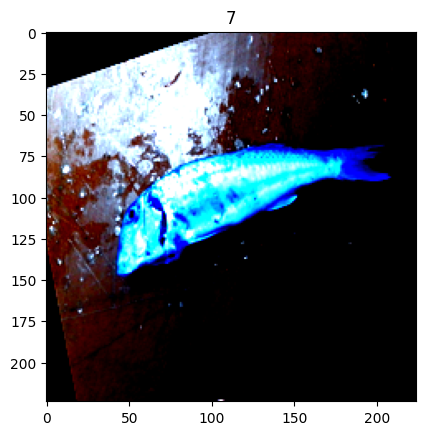

In [11]:
train_dataset=Image_dataset(train,mode="Train")
test_dataset=Image_dataset(test,mode='Test')
# img - train_dataset[0][0]
# label - train_dataset[0][1]

train_loader=DataLoader(train_dataset,batch_size=Config.batch_size_tr,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=Config.batch_size_ts,shuffle=True)

#  проверяем работает ли (DataLoader можно опционально)
fig, ax1 = plt.subplots(1,1)
im = ax1.imshow(train_dataset[0][0], )
ax1.set_title(train_dataset[0][1])
plt.show()

### Choose NN

In [12]:
# score function
def roc_auc_fn(outputs,labels,n_classes=10,mode='micro'):

    y_test=torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=n_classes).detach().numpy()

    y_pred_pre=torch.argmax(torch.softmax(outputs, dim=1),dim=1)
    y_pred=torch.nn.functional.one_hot(y_pred_pre.to(torch.int64), num_classes=n_classes).detach().numpy()

    # 'micro' Вычисляйте метрики глобально, рассматривая каждый элемент матрицы индикаторов меток как метку.
    # 'macro' Рассчитайте показатели для каждого ярлыка и найдите их невзвешенное среднее значение. При этом не учитывается дисбаланс меток.

    # 'ovr' Означает «Один против остальных». Вычисляет AUC каждого класса относительно остальных 
    # 'ovo' Означает «Один против одного». Вычисляет среднее значение AUC всех возможных парных комбинаций классов
    roc_auc= roc_auc_score(
        y_test,
        y_pred,
        average=mode,
    )
    return roc_auc

def save_model(path=None,model=None):
    s=str(path)
    torch.save(model, s)

#### Transformer ResNet-101

In [26]:
# main body 
def epoch_loop(model,loader,loss_fn,score_fn,optimizer,mode):
    avg_loss=0
    avg_score=0
    proc=1
    
    for batch in tqdm(loader):
        x,y=batch[0],batch[1]
        x = x.permute(0, 3, 1, 2)

        output=model(x)

        loss=loss_fn(output.logits,y.long())
        if mode=='Train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        score=score_fn(output.logits,y)
        avg_loss+=loss.item()/len(loader)
        avg_score+=score/len(loader)
        
    if (proc-1)%10==0:
        print(f'batch: {proc}\tloss: {avg_loss}\tacc: {avg_score*100}')
    
    proc+=1

    return avg_loss,avg_score

def train_loop(model,loss_fn,score_fn,optimizer,loader_train,loader_test,model_name,epoches):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_model = None
    best_val_acc = 0.0
    proc=1
    
    for ep in tqdm(range(epoches),desc='Epoces'):

        model.train()
        loss_tr,roc_auc_tr=epoch_loop(model,loader_train,loss_fn,score_fn,optimizer,mode='Train')

        model.eval()
        with torch.no_grad():
            loss_ts,roc_auc_ts=epoch_loop(model,loader_test,loss_fn,score_fn,optimizer,mode='Test')

        if roc_auc_ts > best_val_acc:  # Check if current validation accuracy is better than the best so far
            best_val_acc = roc_auc_ts
            best_model = model.state_dict()
            save_model(path=f'models/{model_name}',model=model.state_dict())

        train_loss.append(loss_tr)
        train_acc.append(roc_auc_tr)
        val_loss.append(loss_ts)
        val_acc.append(roc_auc_ts)
        proc+=1

        print (f'Epoch {ep}: tr_acc {roc_auc_tr},val_acc {roc_auc_ts}...')
        

    return best_model ,(train_loss, val_loss, train_acc, val_acc)
    
def training_fn(model,train_dataloader,test_dataloader,num_classes,learn_rate,model_name,epoches):
    # определяем параметры 
    model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    best_model, history=train_loop(model,criterion,roc_auc_fn,optimizer,train_dataloader,test_dataloader,model_name,epoches)

    return best_model,history

In [16]:
best_model,hist=training_fn(
    model=ResNetForImageClassification.from_pretrained("microsoft/resnet-101"),
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    num_classes=10,
    learn_rate=0.01,
    model_name='fishes_resnet_1',
    epoches=20
)

Epoces:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 1.1792763015107504	acc: 76.83807319223986


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 1.07005903031677	acc: 82.20486111111111
Epoch 0: tr_acc 0.7683807319223986,val_acc 0.8220486111111112...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.29005736798521076	acc: 94.61254409171079


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 1.1884167259559035	acc: 86.54513888888887
Epoch 1: tr_acc 0.9461254409171078,val_acc 0.8654513888888887...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.16647593470083347	acc: 97.01003086419753


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 2.4315785970538855	acc: 76.29123263888889
Epoch 2: tr_acc 0.9701003086419754,val_acc 0.7629123263888888...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.07992177536444998	acc: 98.37411816578484


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.09474992695049878	acc: 98.42664930555559
Epoch 3: tr_acc 0.9837411816578483,val_acc 0.9842664930555558...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.0450484137834301	acc: 99.14572310405643


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.4298924372997135	acc: 93.10980902777781
Epoch 4: tr_acc 0.9914572310405643,val_acc 0.9310980902777781...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.05864563814940907	acc: 99.02171516754848


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.20159107027575374	acc: 97.61284722222226
Epoch 5: tr_acc 0.9902171516754849,val_acc 0.9761284722222225...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.08793056499035587	acc: 98.52568342151675


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.11942596851440612	acc: 97.66710069444447
Epoch 6: tr_acc 0.9852568342151675,val_acc 0.9766710069444448...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.030451953529365472	acc: 99.54530423280417


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.04315016351574741	acc: 99.02343750000001
Epoch 7: tr_acc 0.9954530423280417,val_acc 0.9902343750000001...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.05191314561359051	acc: 99.06305114638451


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.1558892352913972	acc: 97.12456597222227
Epoch 8: tr_acc 0.9906305114638451,val_acc 0.9712456597222227...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.04183537913449403	acc: 99.32484567901228


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.03771700281140511	acc: 99.51171875000001
Epoch 9: tr_acc 0.9932484567901229,val_acc 0.9951171875000001...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.06646444418260618	acc: 98.81503527336861


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.23938793613342568	acc: 96.03949652777783
Epoch 10: tr_acc 0.988150352733686,val_acc 0.9603949652777782...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.039666179472410544	acc: 99.24217372134032


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.019896588466508547	acc: 99.62022569444446
Epoch 11: tr_acc 0.9924217372134032,val_acc 0.9962022569444445...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.04456989761323683	acc: 99.15950176366843


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.05286376470758114	acc: 98.91493055555556
Epoch 12: tr_acc 0.9915950176366843,val_acc 0.9891493055555556...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.04095347317689586	acc: 99.29728835978831


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.10056863909994718	acc: 97.77560763888893
Epoch 13: tr_acc 0.992972883597883,val_acc 0.9777560763888893...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.013745649920551049	acc: 99.73820546737204


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.10508308301359648	acc: 98.04687500000003
Epoch 14: tr_acc 0.9973820546737204,val_acc 0.9804687500000003...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.006833448090002917	acc: 99.8759920634919


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.002651382313047179	acc: 99.94574652777779
Epoch 15: tr_acc 0.9987599206349191,val_acc 0.9994574652777778...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.003383996522022662	acc: 99.93110670193988


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.011921125941967148	acc: 99.7287326388889
Epoch 16: tr_acc 0.9993110670193988,val_acc 0.997287326388889...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.001362814493953169	acc: 99.98622134038784


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.0008077799073546998	acc: 100.0
Epoch 17: tr_acc 0.9998622134038784,val_acc 1.0...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.005016887905113103	acc: 99.88977072310394


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.017232983174380934	acc: 99.56597222222223
Epoch 18: tr_acc 0.9988977072310394,val_acc 0.9956597222222223...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.002485909350475089	acc: 99.97244268077586


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.0016467848462582424	acc: 99.94574652777779
Epoch 19: tr_acc 0.9997244268077585,val_acc 0.9994574652777778...


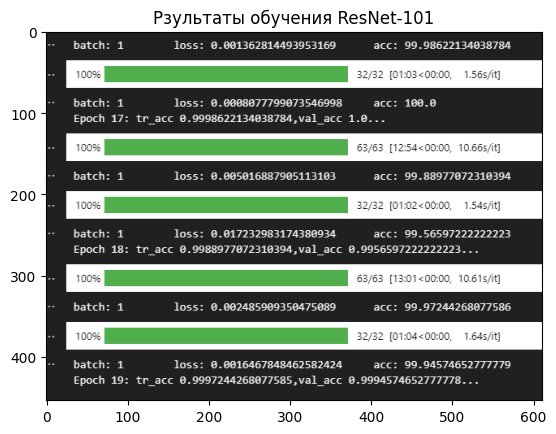

In [61]:
# тк я забыл и обучил сразу за resnet mobilenet
plt.imshow(cv2.imread(r'E:\mphti\training\fish_class\resnet.png'))
plt.title('Рзультаты обучения ResNet-101')
plt.show()

#### Torch MobileNet_V3_small

In [41]:
# немного переделали под новую модель 
def epoch_loop(model,loader,loss_fn,score_fn,optimizer,mode):
    avg_loss=0
    avg_score=0
    proc=1
    
    for batch in tqdm(loader):
        x,y=batch[0],batch[1]
        x = x.permute(0, 3, 1, 2)
        x=x.to('cuda')
        output=model(x)

        loss = loss_fn(output.to('cpu'), y.long())
        if mode=='Train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        score=score_fn(output.to('cpu'),y)
        avg_loss+=loss.item()/len(loader)
        avg_score+=score/len(loader)
        
    if (proc-1)%10==0:
        print(f'batch: {proc}\tloss: {avg_loss}\tacc: {avg_score*100}')
    
    proc+=1

    return avg_loss,avg_score

In [43]:
model_mob = torch.hub.load('pytorch/vision:v0.10.0','mobilenet_v3_small', pretrained=True)
# Замораживание весов, кроме последнего слоя
for param in model_mob.parameters():
    param.requires_grad = False

def training_fn(model,train_dataloader,test_dataloader,num_classes,learn_rate,model_name,epoches):
    # определяем параметры 
    model.classifier = nn.Sequential(
                                        nn.Linear(576, 128),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(128, 10)
                                        ).to('cuda')
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    best_model, history=train_loop(model,criterion,roc_auc_fn,optimizer,train_dataloader,test_dataloader,model_name,epoches)

    return best_model,history

best_model,hist=training_fn(
    model=model_mob.to('cuda'),
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    num_classes=10,
    learn_rate=0.01,
    model_name='fishes_mobilenet_1',
    epoches=20
)

Using cache found in C:\Users\Kirilll/.cache\torch\hub\pytorch_vision_v0.10.0


Epoces:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.9513717118709807	acc: 81.15079365079366


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.43585781240835786	acc: 90.23437499999999
Epoch 0: tr_acc 0.8115079365079366,val_acc 0.9023437499999999...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.30842656583066963	acc: 94.06139770723102


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.2603076279629022	acc: 94.52039930555559
Epoch 1: tr_acc 0.9406139770723102,val_acc 0.9452039930555558...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.22127178335000594	acc: 95.71483686067023


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.2040076635312289	acc: 95.2799479166667
Epoch 2: tr_acc 0.9571483686067023,val_acc 0.952799479166667...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.18867831351974657	acc: 96.26598324514994


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.05737744155339897	acc: 99.13194444444446
Epoch 3: tr_acc 0.9626598324514993,val_acc 0.9913194444444446...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.156426262790485	acc: 96.96869488536151


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.10095606773393229	acc: 97.99262152777781
Epoch 4: tr_acc 0.9696869488536152,val_acc 0.9799262152777781...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.13556879924403295	acc: 97.39583333333336


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.05790355315548368	acc: 98.91493055555559
Epoch 5: tr_acc 0.9739583333333336,val_acc 0.9891493055555558...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.10174103172880318	acc: 98.15365961199295


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.06528773260652088	acc: 98.64366319444446
Epoch 6: tr_acc 0.9815365961199295,val_acc 0.9864366319444446...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.12776082091861304	acc: 97.49228395061733


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.06260920663771685	acc: 98.86067708333334
Epoch 7: tr_acc 0.9749228395061733,val_acc 0.9886067708333335...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.12066747283651715	acc: 97.56117724867725


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.0738500520674279	acc: 98.58940972222224
Epoch 8: tr_acc 0.9756117724867726,val_acc 0.9858940972222224...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.14370302625355263	acc: 96.96869488536156


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.06717607522296021	acc: 98.7521701388889
Epoch 9: tr_acc 0.9696869488536156,val_acc 0.9875217013888891...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.10542890654196818	acc: 98.01587301587305


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.040930230970843695	acc: 99.34895833333334
Epoch 10: tr_acc 0.9801587301587306,val_acc 0.9934895833333335...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.09211595588555883	acc: 98.08476631393302


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.028045329483575188	acc: 99.56597222222223
Epoch 11: tr_acc 0.9808476631393301,val_acc 0.9956597222222223...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.09797009450220873	acc: 97.9469797178131


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.03582530167477671	acc: 99.29470486111113
Epoch 12: tr_acc 0.9794697971781309,val_acc 0.9929470486111113...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.08178410293268303	acc: 98.2363315696649


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.03446518102464324	acc: 99.34895833333334
Epoch 13: tr_acc 0.982363315696649,val_acc 0.9934895833333335...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.08725052634401925	acc: 98.2914462081129


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.05879091268252523	acc: 99.02343750000003
Epoch 14: tr_acc 0.982914462081129,val_acc 0.9902343750000002...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.0973587689315161	acc: 98.002094356261


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.07749429507384775	acc: 98.4809027777778
Epoch 15: tr_acc 0.9800209435626099,val_acc 0.984809027777778...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.10076670802479228	acc: 98.22255291005291


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.02787848438219953	acc: 99.45746527777779
Epoch 16: tr_acc 0.9822255291005292,val_acc 0.9945746527777779...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.09945611914782417	acc: 98.13988095238095


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.03396991285444528	acc: 99.29470486111111
Epoch 17: tr_acc 0.9813988095238094,val_acc 0.9929470486111112...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.14443715840637214	acc: 97.0513668430335


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.06398955779877724	acc: 98.64366319444446
Epoch 18: tr_acc 0.970513668430335,val_acc 0.9864366319444446...


  0%|          | 0/63 [00:00<?, ?it/s]

batch: 1	loss: 0.15667296195077515	acc: 96.87224426807758


  0%|          | 0/32 [00:00<?, ?it/s]

batch: 1	loss: 0.021757921405878733	acc: 99.45746527777779
Epoch 19: tr_acc 0.9687224426807758,val_acc 0.9945746527777778...


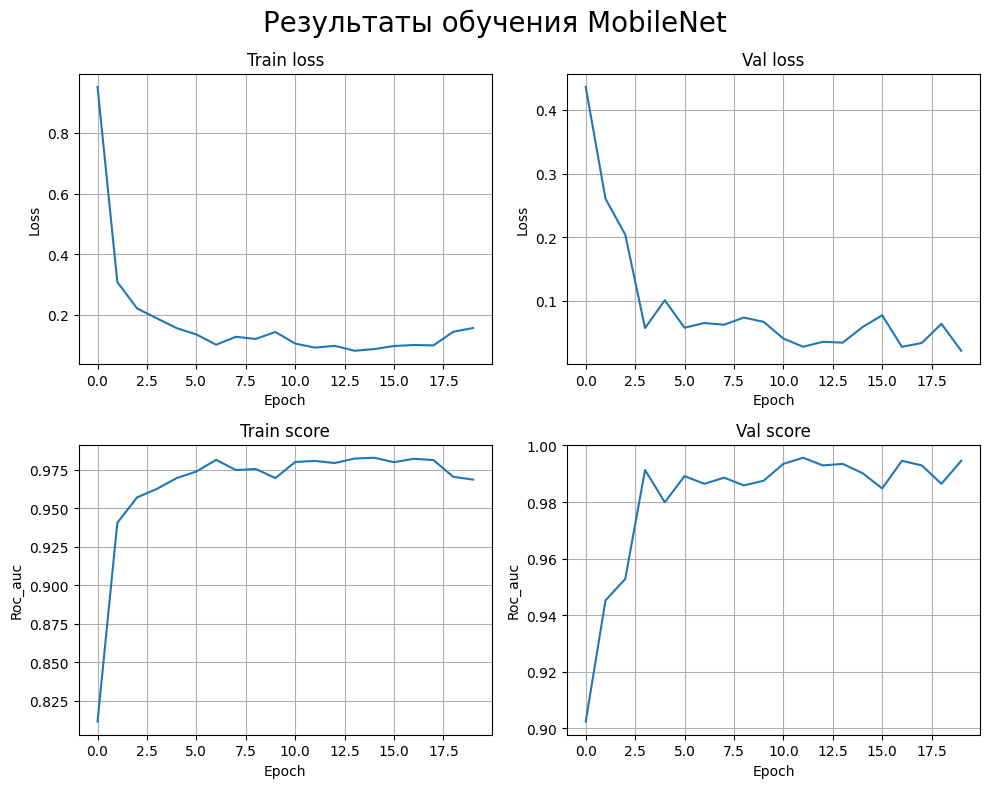

In [56]:
# Создание фигуры и осей
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

epoch=range(20)
# Вывод графиков
axs[0, 0].plot( epoch,hist[0])
axs[0, 0].set_title('Train loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid()

axs[0, 1].plot(epoch,hist[1])
axs[0, 1].set_title('Val loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid()

axs[1, 0].plot(epoch,hist[2])
axs[1, 0].set_title('Train score')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Roc_auc')
axs[1, 0].grid()

axs[1, 1].plot(epoch,hist[3])
axs[1, 1].set_title('Val score')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Roc_auc')
axs[1, 1].grid()

# Вывод графиков на экран
fig.suptitle('Результаты обучения MobileNet', fontsize=20)
plt.tight_layout()
plt.show()

### Predict section

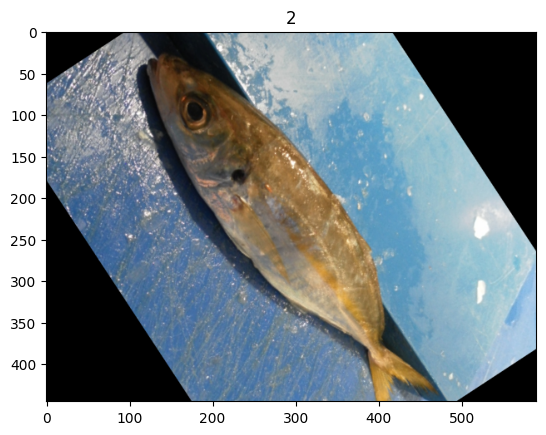

In [44]:
idx=np.random.randint(0,len(test['filename']))
test_filename=test['filename'][idx]
test_img=Image.open(test_filename).convert('RGB')
test_label=test['label'][idx]
plt.imshow(test_img)
plt.title(test_label)
plt.show()

In [45]:
# работает Resnet
# load predicted model
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-101")
# Настроить модель
num_classes = 10
model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
model.load_state_dict(torch.load(r'E:\mphti\training\fish_class\models\resnet_fishes'))

<All keys matched successfully>

In [46]:
def predict_one_image(model,data):
    model.eval()
    img = data.resize((224, 224))
    img=cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    augs = A.Compose([
                A.Normalize(mean=Config.mean, std=Config.std)
                ])
    aug_img=augs(image=img)

    img=torch.Tensor(aug_img['image'])
    img=img.unsqueeze(0).permute(0, 3, 1, 2)

    predict_label=model(img)

    return predict_label

y=predict_one_image(model,test_img)
print (torch.argmax(torch.softmax(y.logits, dim=1),dim=1))

tensor([2])


можно допонить Функцией расчета для всего маччиыв тестовых даннх , но результаты представленны в обучении сетей